In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import subprocess
from scipy.optimize import curve_fit

## Load Data and display tabke

In [2]:
df = pd.read_excel('Hg.xlsx')
df

,order,direction,lambda,degree eyepiece,arcminute eyepiece,degree inlet,arcminute inlet,uncertainty,zero
0,1,1,404.66,14,3,194,2,1,1.5
1,1,1,435.84,15,10,195,8,1,1.5
2,1,1,576.96,20,14,200,13,1,1.5
3,1,1,578.97,20,18,200,18,1,1.5
4,2,1,435.84,31,31,211,30,1,1.5
5,2,1,546.07,40,55,220,55,1,1.5
6,2,1,576.96,43,48,223,48,1,1.5
7,3,1,435.84,51,40,231,36,1,1.5
8,1,-1,404.66,345,58,165,55,1,1.5
9,1,-1,435.84,344,50,164,48,1,1.5


## Send table to an array and transpose it for easy indexing, then pull out all the necessary attributes

In [3]:
arr = df.values.T
eye_d = arr[3]
eye_m = arr[4]
in_d = arr[5]
in_m = arr[6]
orders = arr[0]
lambdas = arr[2]
directions = arr[1]
zero = 0*arr[8]
uncertainties = arr[7]

## Add the zero to the minutes and then convert to degrees from arcminutes

In [4]:
eye_m += zero*directions
in_m += zero*directions
eye_m = eye_m/60
in_m = in_m/60

## Add the converted arcminutes to the degrees

In [5]:
eye_d += eye_m
in_d += in_m

## Find the differences and average the readings from both verniers output which measurements need to be reconsidered

In [6]:
diff = eye_d - (in_d-180)%360
bools = diff>10**(-6)
print('there are {} measurements to recheck, check the arrays for the wavelength and order'.format(np.sum(bools)))
wl = lambdas[bools]
order = orders[bools]
direction = directions[bools]
print(wl)
print(order)
print(direction)
print(eye_d[bools], (in_d[bools]-180)%360)
# for indexing the fit
indices = np.invert(bools)

there are 14 measurements to recheck, check the arrays for the wavelength and order
[404.66 435.84 576.96 435.84 435.84 404.66 435.84 546.07 576.96 578.97
 435.84 546.07 576.96 435.84]
[1. 1. 1. 2. 3. 1. 1. 1. 1. 1. 2. 2. 2. 3.]
[ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 14.05        15.16666667  20.23333333  31.51666667  51.66666667
 345.96666667 344.83333333 340.88333333 339.75       339.66666667
 328.5        319.08333333 316.2        308.33333333] [ 14.03333333  15.13333333  20.21666667  31.5         51.6
 345.91666667 344.8        340.83333333 339.7        339.61666667
 328.45       319.03333333 316.15       308.31666667]


In [7]:
average = (eye_d + (in_d-180)%360)/2
average[average>178] -= 360
print(np.deg2rad(average))

[ 0.24507332  0.26441738  0.35299284  0.35430184  0.54992416  0.71413055
  0.76445421  0.90117167 -0.2453642  -0.26499916 -0.33408511 -0.35386551
 -0.35531995 -0.55021505 -0.71456688 -0.76489054 -0.90189889]


## Now we do a least squares fit given by the following equation

$$ d^{-1}n_k\lambda_k + sin\theta_i = sin\theta_m $$

## To determine $d^{-1}$ and $sin\theta_i$

In [8]:
def f(x, d, thi):
    # could be + or - for where these are
    return d*(np.sin(thi)+np.sin(x-thi))

[0.22421268 0.22250718 0.21351135 0.21336584 0.1895949  0.17135569
 0.16717789 0.16150782 0.22400681 0.22226133 0.21534648 0.21317489
 0.21301232 0.18927311 0.17106466 0.16692014 0.16138307]


<ErrorbarContainer object of 3 artists>

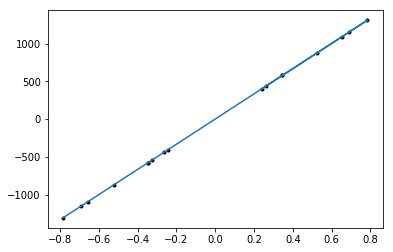

In [9]:
outs = lambdas*orders*directions
ins = np.deg2rad(average)
init = [1/600*10**(6), 0.01]
params, cov = curve_fit(f, ins, outs, p0=init)

d = params[0]
derr = np.sqrt(cov[0,0])
thierr = np.sqrt(cov[1,1])
thi = params[1]

err = (d*np.cos(ins-thi)*np.deg2rad(1/60))**2 + ((np.sin(thi)+np.sin(ins-thi))*derr)**2 + (d*(np.cos(thi)-np.cos(ins-thi))*thierr)**2
print(err)
plt.plot(np.sin(ins), outs, 'k.')
plt.errorbar(np.sin(ins), f(ins, d, thi), yerr=np.sqrt(err))

<ErrorbarContainer object of 3 artists>

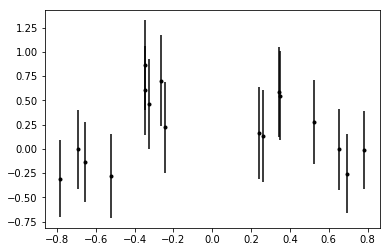

In [10]:
plt.errorbar(np.sin(ins), outs-f(ins,d,thi), yerr=np.sqrt(err), fmt='.k')

In [11]:
print(np.where(abs(outs-f(ins,d,thi))>2), np.mean(abs(outs-f(ins,d,thi))))

(array([], dtype=int64),) 0.32715928556458224


In [12]:
chi2 = (outs-f(ins,d,thi))**2/err
print(chi2, np.sum(chi2), len(chi2))

[1.20976189e-01 7.94396350e-02 1.61964755e+00 1.41978219e+00
 3.98578000e-01 1.84925056e-04 3.90958109e-01 9.07504676e-04
 2.18687162e-01 2.23521500e+00 9.84699390e-01 1.70239340e+00
 3.51571325e+00 4.06987416e-01 1.05497571e-01 1.27632132e-04
 5.81559895e-01] 13.781354818953918 17


1666.9302973232923


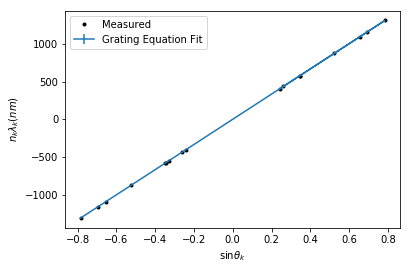

In [13]:
outs = lambdas*orders*directions
ins = np.deg2rad(average)
init = [1/600*10**(6), 0.01]
params, cov = curve_fit(f, ins, outs, p0=init, sigma=1/err)

d = params[0]
thi = params[1]

print(d)
plt.plot(np.sin(ins), outs, 'k.')
plt.errorbar(np.sin(ins), f(ins, d, thi), yerr=np.sqrt(err))
plt.ylabel(r'$n_k\lambda_k(nm)$')
plt.xlabel(r'$\sin\theta_k$')
plt.legend(['Measured','Grating Equation Fit'])
#plt.savefig('bad_fit.png')

Text(0.5, 0, '$\\sin\\theta$')

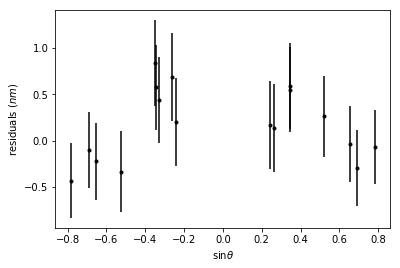

In [14]:
plt.errorbar(np.sin(ins), outs-f(ins,d,thi), yerr=np.sqrt(err), fmt='.k')
plt.ylabel(r'residuals $(nm)$')
plt.xlabel(r'$\sin\theta$')
#plt.savefig('bad_residuals.png')

In [15]:
print(np.where(abs(outs-f(ins,d,thi))>2), np.mean(abs(outs-f(ins,d,thi))))

(array([], dtype=int64),) 0.3484619507059827


In [16]:
chi2 = (outs-f(ins,d,thi))**2/err

In [17]:
print(chi2, np.sum(chi2), len(chi2))

[0.12556854 0.0827169  1.61854387 1.41845273 0.36063667 0.00791853
 0.51518817 0.03073025 0.18534078 2.11276356 0.87135395 1.53857785
 3.27698704 0.59456801 0.28640553 0.06160153 1.15402298] 14.241376891900291 17


In [18]:
np.sqrt(17)

4.123105625617661